# <center> Raport firmy GWINTEX S.A.
## <center> Analiza optymalnej liczby zestawów narzędziowych w zależności od kosztów przestoju i kosztów zestawu narzędzi

<br>Zaawansowane Modelowanie Symulacyjne
<br>234060-0723

**Autorzy**
<br>Filip Mordarski, 76671 
<br>Damian Głowacki, 72384 
<br>Mateusz Dalba, 68734
<br>Dorota Szczęsna, 72569

## 1. Executive Summary

Głównym celem poniższej analizy jest optymalizacja kosztu operacyjnego i inwestycyjnego firmy GWINTEX S.A. za pomocą wyboru odpowiedniego układu ustawienia maszyn produkcyjnych w nowej hali produkcyjnej oraz liczby zestawów narzędzi służących do jego naprawy. Analiza wykazała, że dla przyjętych przedziałów kosztów układ gniazdowy jest wyborem optymalnym, jeśli jednostkowy koszt przestoju maszyny jest wyższy niż 4 jednostki, w przeciwnym wypadku rekomendowany jest układ liniowy. Sugerowana liczba pakietów narzędzi dla obu układów to 2, 3 lub 4 w zależności od wysokości kosztów narzędzi oraz kosztu przestoju. Jeżeli firma planuje dalszy wzrost produkcji rekomendowany jest wybór układu gniazdowego oraz zakup dodatkowych pakietów, ponieważ nie wpływają znacznie na całkowity koszt operacyjny firmy.

## 2. Opis organizacji

Raport został przygotowany na potrzeby firmy GWINTEX S.A. Przedsiębiorstwo to jest potentatem w dziedzinie produkcji korkociągów. W tym celu wykorzystują bardzo nowoczesne maszyny metalurgiczne. Firma ma znaczne udziały zarówno na rynku polskim, jak i  europejskim. Przedsiębiorstwo GWINTEX S.A. wykorzystuje swój potencjał technologiczny jako przewagę konkurencyjną. W związku z postępującą zmianą kultury w piciu alkoholu Polaków, rośnie popyt na wina. Wiąże się to również ze znacznym wzrostem zamówień korkociągów. Poniższy raport pozwoli organizacji na zminimalizowanie swoich kosztów w zależności od sytuacji panującej na rynku. 

## 3. Opis problemu

<br> W związku ze znacznym wzrostem zamówień na produkty firmy GWINTEX S.A., spółka planuje uruchomienie nowej hali produkcyjnej, w której znajdzie się 6 maszyn do produkcji korkociągów. Do każdej maszyny zostanie przydzielony operator, który będzie odpowiedzialny za jej obsługę oraz usuwanie awarii. 

Na podstawie pomiarów historycznych ustalono, że czas bezawaryjnej pracy maszyny ma rozkład wykładniczy ze średnią 75 minut. W przypadku wystąpienia awarii operator będzie musiał zadzwonić do warsztatu z prośbą o dostarczenie pakietu narzędzi naprawczych. Narzędzia te są bardzo ciężki i w związku z tym muszą być transportowane za pomocą przenośnika taśmowego (taśmociągu). Przyjęto, że czas transportu zestawu narzędzi do maszyny jest zmienną losową z rozkładu Erlanga przy parametrze k=3 i średnio wynosi 15 minut. 

Po ukończeniu naprawy narzędzia będą powtórnie umieszczane na taśmociągu i transportowane w komplecie do warsztatu celem ich uzupełnienia. Ze względu na specyfikę specjalistycznych narzędzi nie jest możliwe dokonywanie kolejnych napraw przed powrotem narzędzi do warsztatu. Ze względu na bardzo wysoką cenę jednego pakietu narzędzi naprawczych ich liczba nie może być większa od liczby maszyn w hali produkcyjnej. Gdy w danej chwili pakiet narzędzi nie będzie dostępny operator będzie musiał czekać aż inny pakiet wróci do warsztatu i zostanie mu wysłany.

Zarząd firmy GWINTEX zastanawia się jakie powinno być rozmieszczenie urządzeń na hali produkcyjnej oraz ile pakietów narzędziowych do obsługi maszyn należy zakupić. Rozważane są dwie organizacje hali produkcyjnej – układ liniowy oraz układ gniazdowy. W układzie liniowym czas transportu narzędzi z warsztatu do maszyny wynosi ti=i*2, gdzie i oznacza numer danej maszyny, natomiast w układzie gniazdowym czas ten jest stały i wynosi 3 minuty. Czas transportu narzędzi do warsztatu jest taki sam jak czas transportu do maszyny. Wprowadzenie układu gniazdowego wiąże się z wyższymi kosztami instalacyjnymi związanymi z uruchomieniem sześciu niezależnych taśmociągów.

W celu znalezienia odpowiedzi na powyższe pytania został skonstruowany model symulacyjny firmy z uwzględnieniem dwóch różnych układów produkcyjnych oraz zmiennej liczby narzędzi. Horyzont symulacji, czyli symulowany okres czasu działania firmy wynosi 30 dni, zaś domyślna liczba iteracji czyli powtórzeń symulacji wynosi 10. Oprócz średniego czasu pracy bez usterki oraz średniego czasu naprawy jednej maszyny do modelu zostały dodane następujące zmienne kosztowe:
1. Jednostkowy koszt przestoju maszyny za minutę.
2. Dodatkowy koszt instalacji w ustawieniu gniazdowym ("G") w porównaniu do instalacji liniowej ("L").
3. Koszt zestawu narzędzi.

In [1]:
import numpy as np
import random
import scipy as sc
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings('ignore')

In [2]:
# liczba maszyn
n = 6 

# średni czas pracy bez usterki
avg_working_time = 75 # minut

# średni czas naprawy
avg_repair_time = 15 # minut

# horyzont analizy
horizon = 30 # dni

# liczba uruchomień symulacji
iterations = 10

In [3]:
def model(horizon, avg_working_time, avg_repair_time, n, m, setup, c, cost_inst, m_cost, seed):
    # setup - układ liniowy "L" lub gniazdowy "G"
    
    sc.random.seed(seed)
    
    random.seed(seed)
    
    # horyzont działania w minutach
    horizon = horizon * 24 * 60 
    
    # wektor zdarzeń, który zmienia stan symulacji
    events = list(np.random.exponential(avg_working_time, n))
    
    # status - określa aktualny stan maszyny 
    status = ["W"] * n

    # t_start - określa początek bezczynności maszyny
    t_start = [0] * n

    # t_cum - skumulowany czas bezczynności maszyny
    t_cum = [0] * n

    # tools_loc lokalizacja narzedzi - albo numer maszyny albo -1 czyli warsztat
    tools_loc = [-1] * m

    # tools_occupied czas zajecia zestawu przez naprawianą maszynę
    tools_occupied = [0] * m
    
    # zegar symulacji - najblizsze zadanie, które ma być wykonane
    t = min(events)
    
    #koszt instalacji
    cost_inst = cost_inst if setup=='G' else 0
    
    #koszt narzedzi
    m_costs = m * m_cost
     
    # rozpoczynamy symulacje "skacząc" po kolejnych zdarzeniach  
    while t <= horizon:
        
        # jeżeli zestawy nie są aktualnie zajęte to przenosimy je z powrotem do warsztatu
        for i in range(m):
            if tools_occupied[i] <= t:
                tools_loc[i] = -1

        # wybieramy maszynę, której dotyczy zdarzenie
        machines = []
        for i in range(len(events)):
            if events[i] == t:
                machines.append(i)
        machine = machines[random.randint(0, len(machines)-1)]
        
        """
        Gdy maszyna, której dotyczy zdarzenie ma status "W":
            - to najpierw zaktualizuj wektor t_start dla tej maszyny jako początek jej bezczynności = t.
            - następnie sprawdź czy dostępny jest jakiś zestaw naprawczy. Jezeli nie:
                - to ustaw status maszyny na "Q" 
                - zaktualizuj wektor events podajac mu najkrótszy czas oczekiwania na wolny zestaw.
              Jeżeli tak:
                - ustaw status maszyny na "R"
                - wyznacz czas  potrzebny na naprawę maszyny w zależności od ukladu taśmociągu 
                (czas transportu + czas naprawy)
                - ustaw koniec naprawy jako zdarzenie dla danej maszyny
                - zaktualizuj wektor tools_loc dla odpowiedniego zestawu podając numer maszyny, którą on obsługuje
                - zaktualizuj wektor tools_occupied czasem jaki mu to zajmie (2* transport + naprawa)
        """
        if status[machine] == "W":
            t_start[machine] = t
            tools = - 1
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            if tools == -1 :
                status[machine] = "Q"
                events[machine] = min(tools_occupied)
            else:
                status[machine] = "R"
                if setup == "L":
                    transport_time = 2 * (1 + machine)
                elif setup == "G":
                    transport_time =  3
                else:
                    print("Niepoprawny układ! Należy wybrać układ 'L' lub 'G'!")
                    break
                repair_time = np.random.gamma(3, avg_repair_time/3)
                events[machine] += repair_time + transport_time
                tools_loc[tools] = machine
                tools_occupied[tools] = max(t, tools_occupied[tools]) + repair_time + 2 * transport_time
                
                """
                Gdy maszyna ma status "Q":
                    - wybierz dostępny zestaw naprawczy
                    - ustal status maszyny na "R"
                    - zaktualizuj wektor tools_loc lokalizacją narzedzi i tools_occupied 
                    czasem jaki zajmie ich transport (w dwie strony) i naprawa maszyny
                    -zaktualizuj wektor zdarzeń czasem potrzebnym na naprawę maszyny i transport narzedzi
                """
                
        elif status[machine] == "Q":
            tools = - 1
            for i in range(m):
                if tools_loc[i] == -1:
                    tools = i
                    break
            if tools == -1 :
                status[machine] = "Q"
                events[machine] = min(tools_occupied)
            else:
                status[machine] = "R"
                if setup == "L":
                    transport_time = 2 * (1 + machine)
                elif setup == "G":
                    transport_time =  3
                else:
                    print("zly uklad - moze byc L lub G!")
                    break
                repair_time = np.random.gamma(3, avg_repair_time/3)
                events[machine] += repair_time + transport_time
                tools_loc[tools] = machine
                tools_occupied[tools] = max(t, tools_occupied[tools]) + repair_time + 2 * transport_time 
            """
            Gdy maszyna ma status "R":
                - ustal jej status na "W"
                - wyznacz czas kolejnej awarii i zaktualizuj wektor events
                - wylicz czas bezczynnosci i uzupelnij o niego liste t_cum
            """
            
        else:
            status[machine] = "W"
            events[machine] += np.random.exponential(avg_working_time)
            t_cum[machine] += t - t_start[machine]
        
        # ustalamy nowe t
        t = min(events)
        
    t_cost = [t*c for t in t_cum]
    cost = cost_inst + sum(t_cost) + m_costs
    # wynik skumulowany czas oraz koszt
    return (t_cum, cost)

In [4]:
def run_model (iterations, horizon, avg_working_time, avg_repair_time, n, m, setup, c, cost_inst, m_cost):
    avg_t_cum = []
    avg_t_cost = []
    for i in range (iterations):
        x = model(horizon, avg_working_time, avg_repair_time, n, m, setup, c, cost_inst, m_cost, i)
        avg_t_cum.append(x[0])
        avg_t_cost.append(x[1])
    return (list(map(np.mean, np.transpose(avg_t_cum))), np.mean(avg_t_cost))


## 4. Wyniki analizy

<br> Poniższy rozdział ma na celu przedstawienie wyników analizy przeprowadzonej dla opisanego powyżej problemu. Pomoże wskazać optymalną liczbę zestawów narzędzi, czy optymalnego rozmieszczenia maszyn w zależności od innych parametrów.

### 4.1 Liczba zestawów narzędzi w zależności od kosztów przestoju i kosztów zestawu narzędzi
<br> W tej części raportu zostaną przedstawione wyniki analizy, które mają na celu wskazać optymalną liczbę zestawów narzędzi w zależności od kosztów przestoju i kosztów zestawu narzędzi. Jak zostało powyżej wspomniane, przedsiębiorstwo ma dwie możliwości rozmieszczenia urządzeń na hali produkcyjnej, w układzie liniowym lub gniazdowym. Z tego względu poniższa analiza będzie uwzględniała również te obie możliwości rozmieszczenia. W poszukiwaniu optymalnej liczby zestawu narzędzi, przyjmiemy że koszt instalacji układu gniazdowego jest stały i wynosi 20,000 jednostek. Koszt za jedną jednostkę czasu przestoju będzie badany z zakresu wartości <3;6>, natomiast koszt jednego zestawu narzędzi z przedziału <5000;50000> z granulacją co 1000. Z opisu problemu wynika, że liczba zestawów narzędzi powinna być niższa niż liczba maszyn. Z tego względu analizowana będzie liczba zestawów narzędzi z przedziału <1;5>.

In [5]:
unit_costs = range(3, 7)
tools_costs = range(5000, 51000, 1000)
tools = range(1, 6)
results = {}
cost_inst = 20000
data = pd.DataFrame()

for m in tools:
    for c in unit_costs:
        for m_cost in tools_costs:
            results[(m, c, m_cost, "G")] = run_model(iterations, horizon, avg_working_time, avg_repair_time, 
                                             n, m, "G", c, cost_inst, m_cost)[1]
            results[(m, c, m_cost, "L")] = run_model(iterations, horizon, avg_working_time, avg_repair_time, 
                                             n, m, "L", c, cost_inst, m_cost)[1]
            data = data.append({"Liczba narzedzi": m, "Koszt jedn.": c, "Koszt zestawu": m_cost, "Ustawienie": "G",
                            "Calkowity koszt": results[(m, c, m_cost, "G")]}, ignore_index=True)
            data = data.append({"Liczba narzedzi": m, "Koszt jedn.": c, "Koszt zestawu": m_cost, "Ustawienie": "L",
                            "Calkowity koszt": results[(m, c, m_cost, "L")]}, ignore_index=True)

W pierwszej kolejności zostanie przeanalizowana optymalna liczba narzędzi w układzie liniowym.

In [6]:
dfs = {i: data[(data['Ustawienie']=='L') & (data['Koszt jedn.']==i)].reset_index().\
       pivot("Liczba narzedzi", "Koszt zestawu", "Calkowity koszt") for i in range(3, 7)}

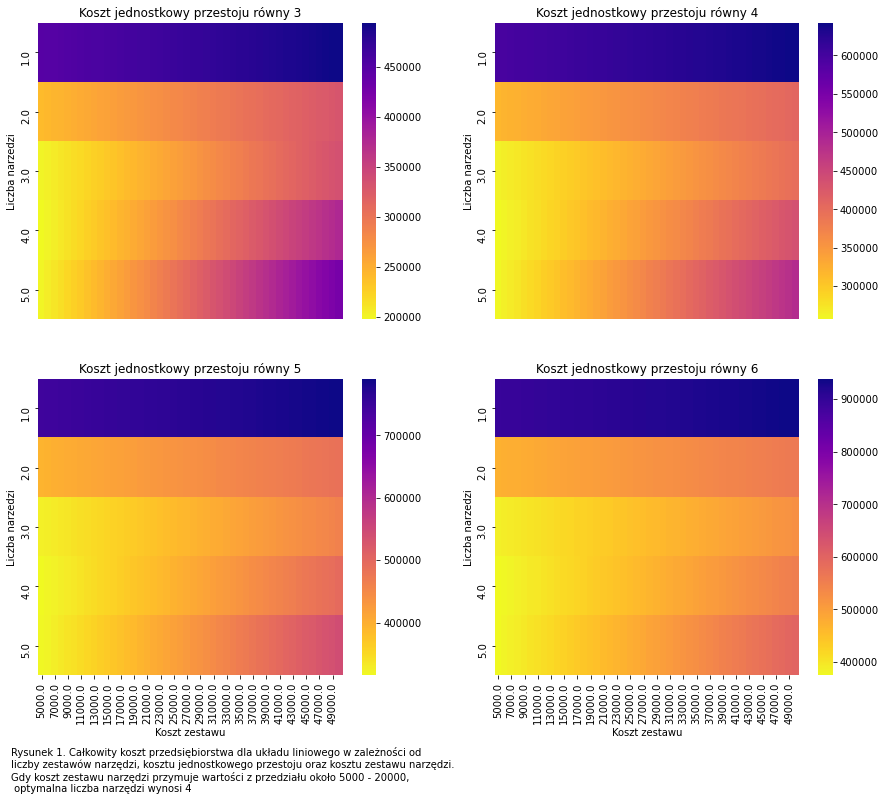

In [7]:
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(dfs[i+3], cmap=cm.plasma_r, ax=ax)
    ax.set_title(f"Koszt jednostkowy przestoju równy {i+3}")
    if i < 2:
        ax.get_xaxis().set_visible(False)
fig2.text(.1, -0.01, "Rysunek 1. Całkowity koszt przedsiębiorstwa dla układu liniowego w zależności od \n"
                     "liczby zestawów narzędzi, kosztu jednostkowego przestoju oraz kosztu zestawu narzędzi.\n"
                     "Gdy koszt zestawu narzędzi przymuje wartości z przedziału około 5000 - 20000,\n " 
                     "optymalna liczba narzędzi wynosi 4", ha='left')        
plt.show()

Na podstawie powyższych wykresów, można wysnuć wniosek że optymalna liczba zestawów narzędzi dla układu liniowego nie zależy w dużym stopniu od poziomu kosztu jednostkowego przestoju. Wykresy, wygenerowane dla różnych wartości kosztu jednostkowego przestoju, różnią się oczywiście wartościami średniego całkowitego kosztu, ale przebieg relatywnych zmian jest podobny. Można to zaobserwować po zmianach natężenia barw. Natomiast, liczba zestawu narzędzi różni się znacznie w zależności od kosztu pojedynczego zestawu narzędzi. Gdy koszt zestawu narzędzi oscyluje w okolicach od 5000 do 20000, optymalna liczba narzędzi wynosi z reguły 4 w większości przypadków jednostkowego kosztu przestoju. Natomiast gdy koszt zestawu przekracza 20000, optymalna liczba narzedzi wynosi 3. Przeanalizujmy jak wygląda dokładny przebieg optymalnego rozwiązania dla układu liniowego oraz różnych kosztów przestoju maszyny.

Text(0.01, 0.001, 'Rysunek 2. Optymalna liczba narzędzi w zależności od kosztu zestawu oraz kosztu jednostkowego \nw układzie liniowym. Optymalna liczba narzędzi znajduje się w zakresie <2;4>, zazwyczaj gdy \nkoszt przestoju jest niższy optymalna liczba narzędzi jest mniejsza.')

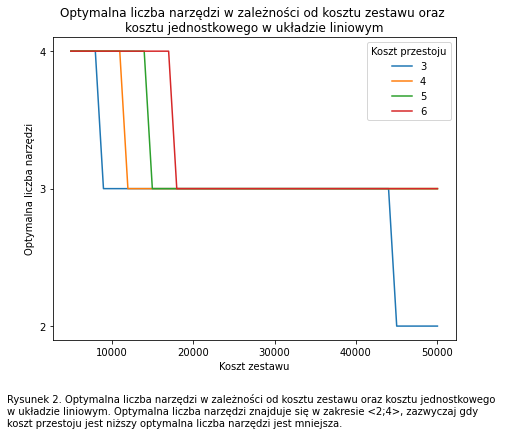

In [8]:
dfs_grouped = {}
for i in range(3, 7):
    df = data[(data['Ustawienie']=='L') & (data['Koszt jedn.']==i)]
    grouped = df.groupby(['Koszt zestawu'])['Calkowity koszt'].min().reset_index()
    final = grouped.merge(df[['Calkowity koszt', "Liczba narzedzi"]], 
                          on='Calkowity koszt', how='left')
    dfs_grouped[i] = final
fig1 = plt.figure(figsize=(7, 6))
ax1 = fig1.add_axes((0.1, 0.2, 0.8, 0.7))
for i in range(3, 7):
    ax1.plot(dfs_grouped[i]['Koszt zestawu'], dfs_grouped[i]['Liczba narzedzi'], label=i)
ax1.legend(loc=1, title='Koszt przestoju')
plt.ylabel('Optymalna liczba narzędzi')
plt.xlabel('Koszt zestawu')
plt.title('Optymalna liczba narzędzi w zależności od kosztu zestawu oraz \n'
          'kosztu jednostkowego w układzie liniowym')
plt.yticks([2, 3, 4])
fig1.text(.01, .001, 
          "Rysunek 2. Optymalna liczba narzędzi w zależności od kosztu zestawu oraz kosztu jednostkowego \n"
          "w układzie liniowym. Optymalna liczba narzędzi znajduje się w zakresie <2;4>, zazwyczaj gdy \n"
          "koszt przestoju jest niższy optymalna liczba narzędzi jest mniejsza.")

Na podstawie powyższego wykresu, można zauważyć, że dla mniejszych wartości jednostkowego kosztu przestoju, optymalna liczba narzędzi jest niższa. Przykładowo, dla kosztu jednostkowego równego 3, optymalna liczba narzędzi spada z 4 do 3 gdy koszt zestawu jest niższy niż 10000. Natomiast, gdy koszt jednostkowego przestoju wynosi 6, optymalna liczba narzędzi spada do 3, gdy koszt zestawu wynosi około 20000. Generalnie, najczęściej występującym rozwiązaniem optymalnem jest wartość 3. Taka liczba zestawów narzędzi jest rekomendowana dla przedsiębiorstwa, gdy maszyny są ustawione w układzie liniowym. Analogicznie zostanie przeprowadzona analiza dla układu gniazdowego.

Text(0.1, -0.01, 'Rysunek 3. Całkowity koszt przedsiębiorstwa dla układu gniazdowego w zależności od \nliczby zestawów narzędzi, kosztu jednostkowego przestoju oraz kosztu zestawu narzędzi.\nGdy koszt zestawu narzędzi przymuje wartości z przedziału około 5000 - 20000,\n optymalna liczba narzędzi najczęściej wynosi 3')

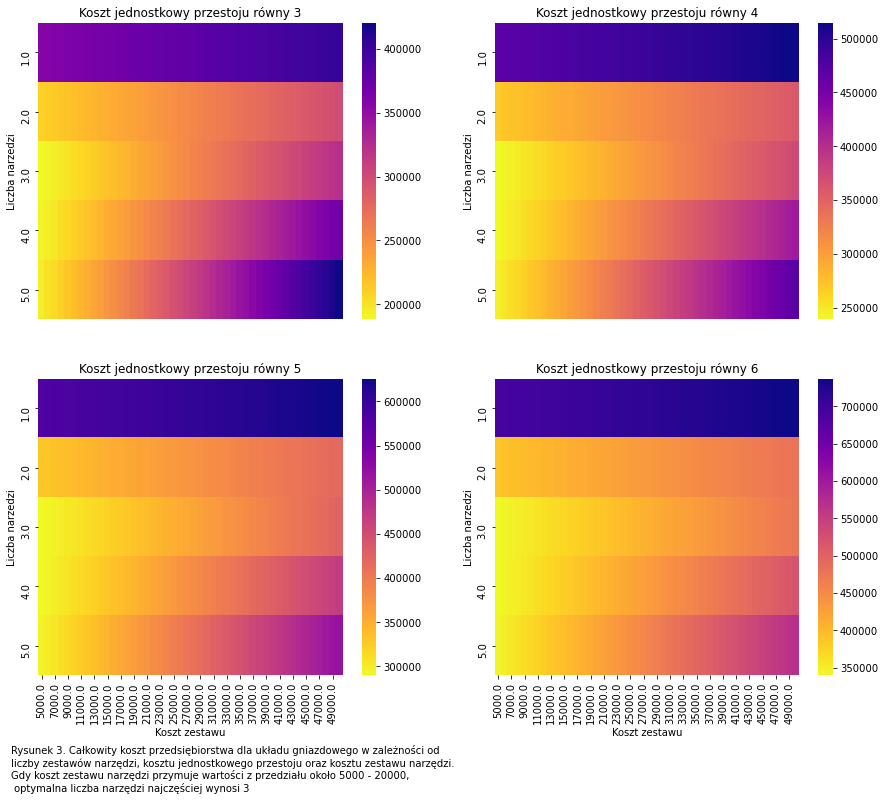

In [9]:
dfs_g = {i: data[(data['Ustawienie']=='G') & (data['Koszt jedn.']==i)].reset_index().\
       pivot("Liczba narzedzi", "Koszt zestawu", "Calkowity koszt") for i in range(3, 7)}
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(dfs_g[i+3], cmap=cm.plasma_r, ax=ax)
    ax.set_title(f"Koszt jednostkowy przestoju równy {i+3}")
    if i < 2:
        ax.get_xaxis().set_visible(False)
fig2.text(.1, -0.01, "Rysunek 3. Całkowity koszt przedsiębiorstwa dla układu gniazdowego w zależności od \n"
                     "liczby zestawów narzędzi, kosztu jednostkowego przestoju oraz kosztu zestawu narzędzi.\n"
                     "Gdy koszt zestawu narzędzi przymuje wartości z przedziału około 5000 - 20000,\n " 
                     "optymalna liczba narzędzi najczęściej wynosi 3", ha='left')        

Na podstawie powyższych wykresów, można wysnuć wniosek, że w układzie gniazdowym mamy do czynienia z podobną sytuacją jak w układzie liniowym. Przebieg zmiany natężenia barw w powyższych 'heatmapach' sugeruje, że optymalna liczba urządzeń zmienia się w podobny sposób dla różnych kosztów jednostkowego przestoju. Warto zauważyć, że wartości na skali barw są mniejsze dla każdego z przedstawionych wykresów. Może to sugerować, że układ gniazdowy jest optymalniejszym rozstawieniem niż układ liniowy. Zostaną przeanalizowane dokładne rozwiązania optymalne w zależności od kosztu przestoju oraz kosztu zestawu narzędzi dla układu gniazdowego.

Text(0.01, 0.001, 'Rysunek 4. Optymalna liczba narzędzi w zależności od kosztu zestawu oraz kosztu jednostkowego \nw układzie gniazdowym. Optymalna liczba narzędzi znajduje się w zakresie <2;4>, zazwyczaj gdy \nkoszt przestoju jest niższy optymalna liczba narzędzi jest mniejsza.')

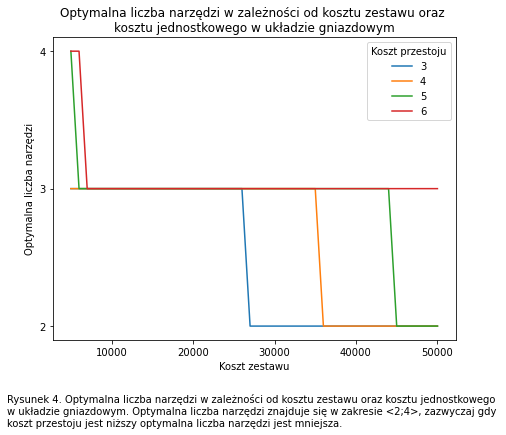

In [10]:
dfs_grouped = {}
for i in range(3, 7):
    df = data[(data['Ustawienie']=='G') & (data['Koszt jedn.']==i)]
    grouped = df.groupby(['Koszt zestawu'])['Calkowity koszt'].min().reset_index()
    final = grouped.merge(df[['Calkowity koszt', "Liczba narzedzi"]], 
                          on='Calkowity koszt', how='left')
    dfs_grouped[i] = final
fig1 = plt.figure(figsize=(7, 6))
ax1 = fig1.add_axes((0.1, 0.2, 0.8, 0.7))
for i in range(3, 7):
    ax1.plot(dfs_grouped[i]['Koszt zestawu'], dfs_grouped[i]['Liczba narzedzi'], label=i)
ax1.legend(loc=1, title='Koszt przestoju')
plt.ylabel('Optymalna liczba narzędzi')
plt.xlabel('Koszt zestawu')
plt.title('Optymalna liczba narzędzi w zależności od kosztu zestawu oraz \n'
          'kosztu jednostkowego w układzie gniazdowym')
plt.yticks([2, 3, 4])
fig1.text(.01, .001, 
          "Rysunek 4. Optymalna liczba narzędzi w zależności od kosztu zestawu oraz kosztu jednostkowego \n"
          "w układzie gniazdowym. Optymalna liczba narzędzi znajduje się w zakresie <2;4>, zazwyczaj gdy \n"
          "koszt przestoju jest niższy optymalna liczba narzędzi jest mniejsza.")

Z powyższego wykresu wynika, że najczęstsza optymalna liczba narzędzi to 3. Co ciekawe, podobnie często występującym rozwiązaniem optymalnym była liczba 2. Powyższy wykres dla układu gniazdowego również sugeruje, że wraz z większym kosztem przestoju maszyny optymalna liczba narzędzi jest wyższa dla danego kosztu zestawu. W celu pogłębionej analizy problemu optymalnej liczby narzędzi została podjęta próba utworzenia drzewa decyzyjnego.  

In [11]:
grouped = data.groupby(["Ustawienie", 'Koszt zestawu', "Koszt jedn."])['Calkowity koszt'].min().reset_index()
grouped = grouped.merge(data[['Calkowity koszt', "Liczba narzedzi"]], 
                          on='Calkowity koszt', how='left')

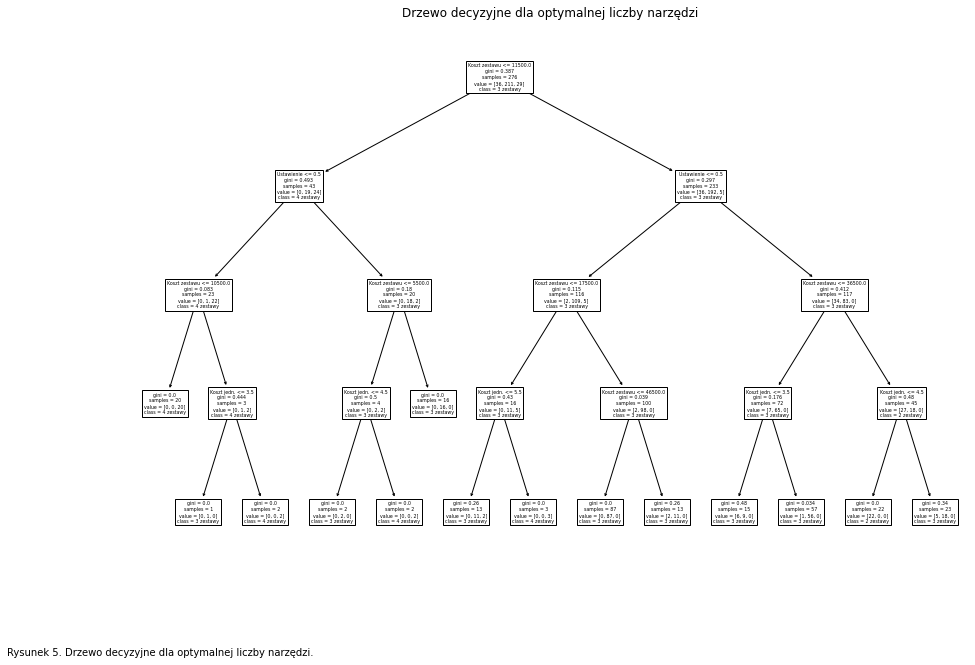

In [12]:
grouped = data.groupby(["Ustawienie", 'Koszt zestawu', "Koszt jedn."])['Calkowity koszt'].min().reset_index()
grouped = grouped.merge(data[['Calkowity koszt', "Liczba narzedzi"]], 
                          on='Calkowity koszt', how='left')
d = {'L': 0, 'G': 1}
grouped['Ustawienie'] = grouped['Ustawienie'].map(d)
features = ["Ustawienie", 'Koszt zestawu', "Koszt jedn."]
# X = grouped[features]
# y = grouped["Liczba narzedzi"]
X_train, X_test, Y_train, Y_test = train_test_split(grouped[features], grouped["Liczba narzedzi"], random_state=0)
dtree = DecisionTreeClassifier(max_depth=4, random_state=0)
dtree = dtree.fit(X_train, Y_train)
score = dtree.score(X_test, Y_test)
fig1 = plt.figure(figsize=(15, 10))
tree.plot_tree(dtree, feature_names=features,
              class_names=['2 zestawy', '3 zestawy', '4 zestawy'])
plt.title('Drzewo decyzyjne dla optymalnej liczby narzędzi')
fig1.text(.01, .001, 
          "Rysunek 5. Drzewo decyzyjne dla optymalnej liczby narzędzi.")
fig1.savefig('tree.png')

W pierwszej kolejności zestaw danych został podzielony na zbiór uczący (75 % pierwotnego zbioru) oraz testowy (25 % pierwotnego zbioru). Następnie został utworzony model drzewa decyzyjnego z maksymalną głebokością korzeni równą 4, aby model nie został zbyt przeuczony. Na powyższym wykresie jest zwizualizowane drzewo decyzyjyne. Nie jest ono zbyt czytelne w jupyter notebooku, więc zostało zapisane do oddzielnego pliku. Takie drzewo decyzyjne będzie pomocne dla przedsiębiorstwa w kwestii podjęcia dezycji odnośnie optymalnej liczby narzędzi. Zostanie przedstawiona jedna wybrana reguła z powyższego drzewa: jeżeli koszt zestawu jest z przedziału (11500;17500> jednostek oraz jednostkowy koszt przestoju jest większy niż 5.5 w układzie liniowym, to przedsiębiorstwo powinno kupić 4 zestawy narzędzi.

### 4.2 Analiza wyboru optymalnego układu produkcyjnego w zależności od jednostkowego kosztu przestoju i różnicy w koszcie instalacji.
<br> W tej części raportu przeanalizowano wpływ zmiany jednostkowego kosztu przestoju oraz różnicy w koszcie instalacji na wybór optymalnego układu produkcyjnego. Zgodnie z logiką firma chce minimalizować koszty, a więc wybierze ten układ dla którego będą one najmniejsze. Dlatego analizowaną wielkością na podstawie której można dokonać wyboru będzie koszt całkowity jaki ponosi przedsiębiorstwo przy danym układzie produkcyjnym. Do przeprowadzenia symulacji przyjęto zakres kosztu jednostkowego  od 1 do 11 jednostek za minutę. Natomiast przedział kosztu instalacji ustalono w granicach od 16  do 60  tys. z granulacją co 1 tys. . Dodatkowo przyjęto, że firma posiada 6 zestawów narzędzi, a koszt jednego zestawu ustalono na poziomie 20 tys. (przy czym należy zaznaczyć, że w tym wypadku koszt zestawu nie ma wpływu na wybór układu produkcyjnego gdyż nie zmienia on realnej różnicy w koszcie całkowitym pomiędzy danymi układami)

In [13]:
unit_costs = range(1, 12)
m_cost = 20000
results = {}
cost_instalments = range(16000, 60001, 1000)
data_G = pd.DataFrame()
data_L = pd.DataFrame()
m = 6  #stała liczba narzędzi



for cost_inst in cost_instalments:
    for c in unit_costs:
        results[(m, c, cost_inst, "G")] = run_model(iterations, horizon, avg_working_time, avg_repair_time, 
                                         n, m, "G", c, cost_inst, m_cost)[1]
        
        results[(m, c, cost_inst, "L")] = run_model(iterations, horizon, avg_working_time, avg_repair_time, 
                                         n, m, "L", c, cost_inst, m_cost)[1]
        #print("Dla liczby zestawów narzędzi równej ", m, "oraz kosztu jednostkowego przestoju: ", c, 
        #      "i kosztu instalacji: ", cost_inst, " całkowity koszt w układzie gniazdowym wynosi: ", 
        #      round(results[(m, c, cost_inst, "G")], 2), " a w układzie liniowym wynosi: ", 
        #      round(results[(m, c, cost_inst, "L")], 2))
        data_G = data_G.append({"Koszt jedn.": c, "Koszt instalacji": cost_inst, "Ustawienie": "G",
                        "Calkowity koszt": results[(m, c, cost_inst, "G")]}, ignore_index=True)
        data_L = data_L.append({"Koszt jedn.": c, "Koszt instalacji": cost_inst, "Ustawienie": "L",
                        "Calkowity koszt": results[(m, c, cost_inst, "L")]}, ignore_index=True)
        

In [14]:
#Przygotowanie danych

data_G_L = pd.DataFrame({'Koszty_G': data_G['Calkowity koszt'], 'Koszty_L': data_L['Calkowity koszt'], 
                         'Koszt_Inst': data_G['Koszt instalacji'], 'Koszt_Jedn.': data_G['Koszt jedn.']})

data_G_L = data_G_L.assign(Min = lambda d: d[['Koszty_G', 'Koszty_L']].min(1))
data_G_L['Ustawienie'] = np.where(data_G_L['Koszty_G'] == data_G_L['Min'], 1, 0) # G = 1, L = 0
GL = data_G_L.pivot("Koszt_Inst", "Koszt_Jedn.",  "Ustawienie")

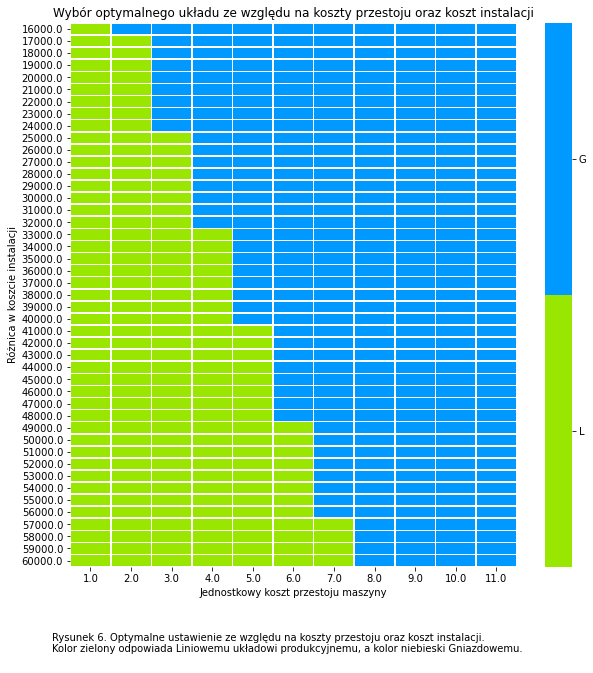

In [15]:
fig, ax = plt.subplots(figsize=(10,10))  

ax.set_title("Wybór optymalnego układu ze względu na koszty przestoju oraz koszt instalacji")

colors = ((0.6, 0.9, 0.0), (0, 0.6, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

sns.heatmap(GL, linewidths=.6, cmap = cmap)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(['L', 'G'])


plt.ylabel("Różnica w koszcie instalacji")

plt.xlabel("Jednostkowy koszt przestoju maszyny")

fig.text(.1, -0.01, "Rysunek 6. Optymalne ustawienie ze względu na koszty przestoju oraz koszt instalacji. \n"
                     "Kolor zielony odpowiada Liniowemu układowi produkcyjnemu, a kolor niebieski Gniazdowemu. \n", ha='left')
j = 0

Na rysunku nr 6 widać, który układ produkcyjny będzie optymalny przy danych parametrach. Można zauważyć, że wraz ze wzrostem kosztu przestoju przewagę nad układem liniowym uzyskuje układ gniazdowy co jest zgodne z intuicją, gdyż przy takim układzie każda maszyna jest zlokalizowana w takiej samej (stosunkowo niedużej) odległości od warsztatu a więc czas dostarczenia narzędzi do zepsutej maszyny jest krótszy niż w przypadku układu liniowego co z kolei przekłada się na niższe koszty całkowite. 

Na podstawie powyższego rysunku, znając przybliżone wielkości kosztu przestoju i dodatkowego kosztu instalacji układu gniazdowego oraz przy założeniu stałej liczby narzędzi, firma będzie w stanie dość precyzyjnie ustalić optymalny układ produkcyjny. 

Z wykresu wynika również pewnego rodzaju stosunek pomiędzy kosztem instalacji a kosztem przestoju, a mianowicie można zauważyć, że jeśli koszt przestoju spadnie o jedną jednostkę to różnica w koszcie instalacji może spaść maksymalnie o około 8 tys. a rozwiązanie optymalne się nie zmieni. Przykładowo jeśli koszt przestoju wynosi 5, a koszt instalacji wynosi 40 tys. to rozwiązaniem optymalnym jest układ gniazdowy. Jeśli koszt przestoju wzrośnie o 1, koszt instalacji może (ale nie musi) wynieść 48 tys. i nadal układ gniazdowy będzie układem optymalnym.

Aby jeszcze lepiej zobrazować tą liniową zależność, poniżej skonstruowano wykres dla przykładowej wartości instalacji równej 40 tys.

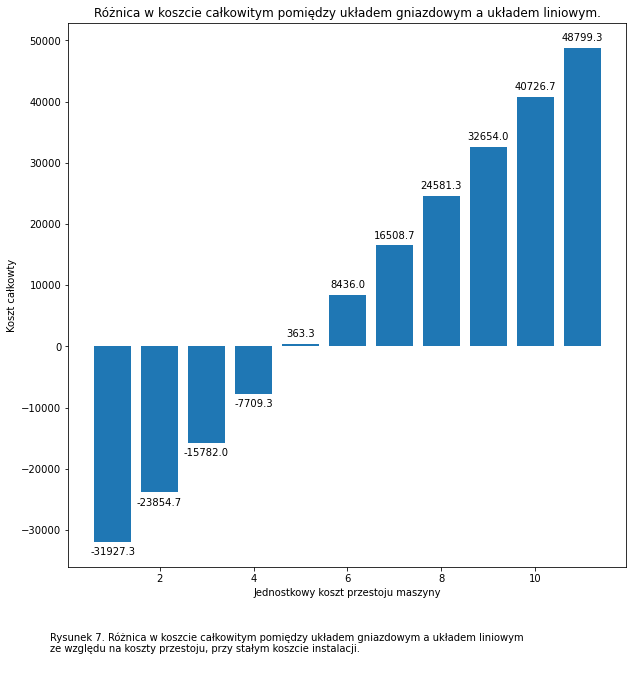

In [19]:
test = data_G_L[data_G_L['Koszt_Inst'] == 40000]
test['Różnica'] = test['Koszty_L']-test['Koszty_G']
x_labels = test['Różnica'].tolist()

fig, ax = plt.subplots(figsize=(10,10))  
plt.bar(test['Koszt_Jedn.'], test['Różnica'])
ax.set_title("Różnica w koszcie całkowitym pomiędzy układem gniazdowym a układem liniowym.")
plt.ylabel("Koszt całkowty")
plt.xlabel("Jednostkowy koszt przestoju maszyny")

fig.text(.1, -0.01, "Rysunek 7. Różnica w koszcie całkowitym pomiędzy układem gniazdowym a układem liniowym \n"
                     "ze względu na koszty przestoju, przy stałym koszcie instalacji. \n", ha='left')


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)


Wykres nr 7 przedstawia różnice w koszcie całkowitym pomiędzy układem gniazdowym a układem liniowym w zależności od zmiany jednostkowego kosztu przestoju dla stałej wartości kosztu instalacji równej 40 tys. Wzrost kosztu przestoju o 1 jednostkę skutkuje wzrostem kosztu całkowitego o około 8 tys. wynika z tego, że wartość ta jest współczynnikiem nachylenia krzywej.

Z wykresu można również odczytać, że dla wartości kosztu instalacji równej 40 tys. optymalne rozwiązania dla układu liniowego znajdują się poniżej osi x, czyli dla kosztu przestoju mniejszego lub równego 4 , zaś optymalne rozwiązania dla układu gniazdowego znajdują się powyżej osi x, czyli dla kosztu przestoju większego lub równego 5.

### 4.3 Analiza wyboru optymalnego układu produkcyjnego i liczby narzędzi w zależności od trzech rodzajów kosztów.
<br>W tej części przeanalizowano zmiany optymalnej decyji w zależności od trzech kosztów: ceny narzędzi, kosztu przestoju i różnicy w koszcie między układem liniowym i gniazdowym. W symulacji koszt jednostkowy przestoju przyjęto z przedziału od 3 do 6, koszt narzędzi z przedziału od 5000 do 30000 co 5000 oraz różnicę w koszcie instalacji z przedziału od 16000 do 26000 co 5000.  

In [20]:
unit_costs = range(3, 7)
tools_costs = range(5000, 31000, 5000)
tools = range(1, 6)
results = {}
data = pd.DataFrame()
cost_instalments = range(16000, 30001, 5000)

for cost_inst in cost_instalments:
    for m in tools:
        for c in unit_costs:
            for m_cost in tools_costs:
                results[(m, c, m_cost, "G",cost_inst)] = run_model(iterations, horizon, avg_working_time, avg_repair_time, 
                                                 n, m, "G", c, cost_inst, m_cost)[1]
                results[(m, c, m_cost, "L",cost_inst)] = run_model(iterations, horizon, avg_working_time, avg_repair_time, 
                                                 n, m, "L", c, cost_inst, m_cost)[1]
                data = data.append({"Liczba narzedzi": m, "Koszt jedn.": c, "Koszt zestawu": m_cost, "Ustawienie": "G", "Koszt instalacji":cost_inst,
                                "Calkowity koszt": results[(m, c, m_cost, "G",cost_inst)]}, ignore_index=True)
                data = data.append({"Liczba narzedzi": m, "Koszt jedn.": c, "Koszt zestawu": m_cost, "Ustawienie": "L","Koszt instalacji":cost_inst,
                                "Calkowity koszt": results[(m, c, m_cost, "L",cost_inst)]}, ignore_index=True)

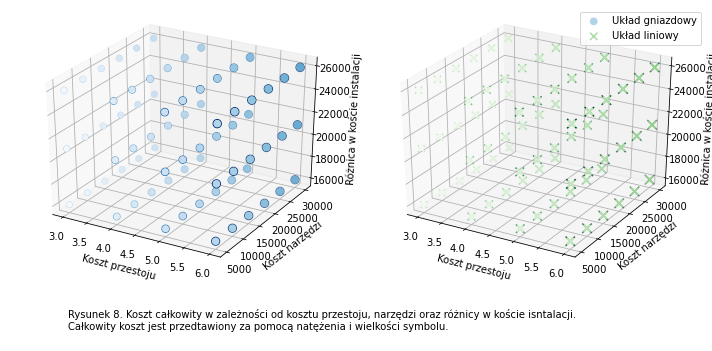

In [21]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(
    figsize=plt.figaspect(0.4)
)
ax = fig.add_subplot(1, 2, 1, projection='3d')


z_line = data[data["Ustawienie"]=="G"]["Koszt instalacji"]
x_line = data[data["Ustawienie"]=="G"]["Koszt jedn."]
y_line = data[data["Ustawienie"]=="G"]["Koszt zestawu"]
s_line = data[data["Ustawienie"]=="G"]["Calkowity koszt"]/10000

z_lineL = data[data["Ustawienie"]=="L"]["Koszt instalacji"]
x_lineL= data[data["Ustawienie"]=="L"]["Koszt jedn."]
y_lineL = data[data["Ustawienie"]=="L"]["Koszt zestawu"]
s_lineL = data[data["Ustawienie"]=="L"]["Calkowity koszt"]/10000



scat1=ax.scatter3D(x_line, y_line, z_line, 'gray',marker='o',s=s_line,c=s_line, cmap = cm.Blues)
ax.set_xlabel("Koszt przestoju")
ax.set_ylabel("Koszt narzędzi")
ax.set_zlabel("Różnica w koście instalacji")

ax = fig.add_subplot(1, 2, 2, projection='3d')



scat2=ax.scatter3D(x_lineL, y_lineL, z_lineL, 'gray', marker='x',s=s_lineL,c=s_lineL, cmap = cm.Greens)
ax.set_xlabel("Koszt przestoju")
ax.set_ylabel("Koszt narzędzi")
ax.set_zlabel("Różnica w koście instalacji")
#ax.set_title("Koszt całkowity w zależności od trzech rodzajów kosztu.",size=14,loc='left')
ax.legend([scat1, scat2], ['Układ gniazdowy', 'Układ liniowy'], numpoints = 1,loc="upper right")
plt.tight_layout()
fig.text(.1, -0.2, "Rysunek 8. Koszt całkowity w zależności od kosztu przestoju, narzędzi oraz różnicy w koście isntalacji. \n"
                     "Całkowity koszt jest przedtawiony za pomocą natężenia i wielkości symbolu. \n", ha='left')
plt.show()

Rysunek 8 przedstawia zmiany kosztu całkowitego instalacji w zależności od trzech typów kosztu. Całkowity koszt jest przedstawiony za pomocą natężenia i wielkości symbolu w celu lepszej identyfikacji trendu. Tendencja dla obu układów jest podobna. Najsilnijeszy wpływ na wzrost kosztu całkowitego ma kosztu przestoju przy niezmienionych pozostałych kosztach. Dla ustalonego jednostkowego kosztu przestoju zmiany kosztu narzędzi oraz różnicy w koście instalacji nie powodują znacznego wzrostu kosztu całkowitego.

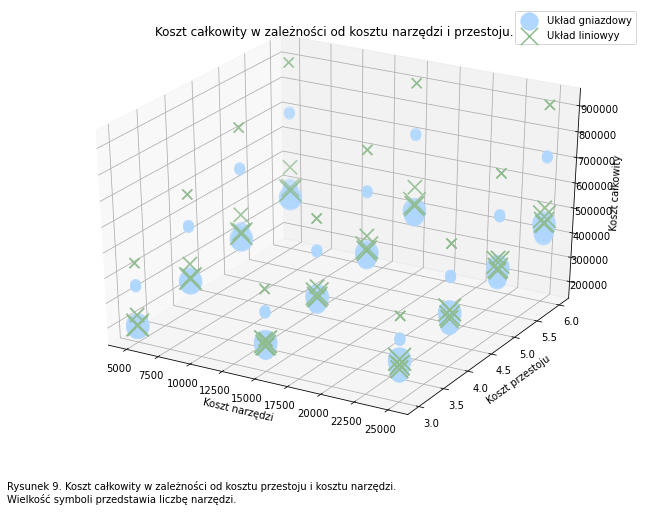

In [22]:
fig = plt.figure(figsize=(11, 8))
ax = plt.axes(projection="3d")
koszt=[5000,15000,25000]
data1=data[data['Koszt zestawu'].isin(koszt)]
z_line = data1[data1["Ustawienie"]=="G"]["Calkowity koszt"]
y_line = data1[data1["Ustawienie"]=="G"]["Koszt jedn."]
x_line = data1[data1["Ustawienie"]=="G"]["Koszt zestawu"]
s_line = data1[data1["Ustawienie"]=="G"]["Liczba narzedzi"]*100

z_lineL = data1[data1["Ustawienie"]=="L"]["Calkowity koszt"]
y_lineL= data1[data1["Ustawienie"]=="L"]["Koszt jedn."]
x_lineL = data1[data1["Ustawienie"]=="L"]["Koszt zestawu"]
s_lineL = data1[data1["Ustawienie"]=="L"]["Liczba narzedzi"]*100

scat1=ax.scatter3D(x_line, y_line, z_line, 'gray', label="Układ gniazdowy",marker='o',s=s_line,c="#afd7ff")
scta2=ax.scatter3D(x_lineL, y_lineL, z_lineL, 'gray',label="Układ liniowyy", marker='x',s=s_lineL,c='#8fbc8f')
ax.set_title("Koszt całkowity w zależności od kosztu narzędzi i przestoju.",size=12)

ax.set_ylabel("Koszt przestoju")
ax.set_xlabel("Koszt narzędzi")
ax.set_zlabel("Koszt całkowity")
ax.legend()

fig.text(.1, -0.001, "Rysunek 9. Koszt całkowity w zależności od kosztu przestoju i kosztu narzędzi. \n"
                     "Wielkość symboli przedstawia liczbę narzędzi. \n", ha='left')
plt.show()

Analiza kosztu całkowitego w zależności od kosztu narzędzi oraz kosztu przestoju została przedstawiona na wykresie powyżej. Wielkość symboli przedstawia liczbę narzędzi. Przeprowadzona symulacja dla trzech typów kosztów wykazuje, że układ gniazdowy w każdym scenariuszu jest optymalny (najniższy koszt całkowity), szczególnie dla niższej liczby narzędzi. Scenariusze dla różnych kosztów narzędzi są podobne dla obu układów, za to koszt całkowity znacznie rośnie przy zmianie kosztu przestoju ceteris paribus. Warto także zauważyć, że liczba narzędzi nie różnicuje silnie kosztu całkowitego. Jeżeli przyjmie się liczbę narzędzi na poziomie 1, koszt jest dużo większy niż dla pozostałych wariantów liczby narzędzi, dla których koszt całkowity pozostaje na podobnym poziomie.

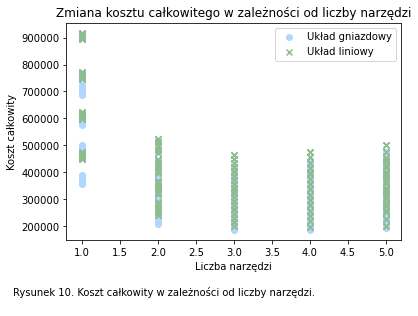

In [23]:
y_line = data[data["Ustawienie"]=="G"]["Calkowity koszt"]
#y_line = data[data["Ustawienie"]=="G"]["Koszt jedn."]
#x_line = data[data["Ustawienie"]=="G"]["Koszt zestawu"]
x_line = data[data["Ustawienie"]=="G"]["Liczba narzedzi"]

y_lineL = data[data["Ustawienie"]=="L"]["Calkowity koszt"]
#y_lineL= data[data["Ustawienie"]=="L"]["Koszt jedn."]
#x_lineL = data[data["Ustawienie"]=="L"]["Koszt zestawu"]
x_lineL = data[data["Ustawienie"]=="L"]["Liczba narzedzi"]

plt.scatter(x_line,y_line,marker="o",c="#afd7ff",label="Układ gniazdowy")
plt.scatter(x_lineL,y_lineL,marker="x",c='#8fbc8f',label="Układ liniowy")

plt.ylabel("Koszt całkowity")
plt.xlabel("Liczba narzędzi")
plt.legend(loc='upper right')
plt.title("Zmiana kosztu całkowitego w zależności od liczby narzędzi")

plt.text(.1, -100000, "Rysunek 10. Koszt całkowity w zależności od liczby narzędzi. \n", ha='left')
plt.show()

Na wykresie 10 graficznie zaprezentowano zależność liczby narzędzi od kosztu całkowitego. Przyjęcie liczby narzędzi na poziomie 1 jest nieoptymalne, ponieważ koszty całkowite są znacznie większe w stosunku do pozostałych wariantów. Jednakże w takim układzie układ gniazdowy byłby optymalnym wyborem. Należy zauważyć, że wraz z kupnem dodatkowych narzędzi koszt całkowity nie zmienia się znacznie oraz układ gniazdowy wciąż pozostaje optymalnym wyborem.

### 4.4 Analiza wpływu ilości symulacji oraz układu maszyn na średnie koszta. 

W celu zbadania wpływu iteracji oraz rozmieszczenia maszyn na średni koszt całkowity, początkowo
przeprowadzono symulację przy założeniu stałych jednostkowych kosztów przestoju,
wynoszących 6 jednostek/min. Liczba maksymalnej liczby symulacji = 50.
Koszt narzędzi na poziomie 5000 jednostek oraz stałą różnicę pomiędzy 
kosztem instalacji układu gniazdowego a liniowego wynoszącą 20 000 jednostek. Rozłożenie średnich kosztów w zależności od liczby iteracji oraz układu rozmieszczenia maszyn
przedstawione zostało na poniższym wykresie.

In [84]:
n = 6 
avg_working_time = 75 # minut
avg_repair_time = 15 # minut
m = 6
horizon = 30 # dni
iterations = 50

def run_model_3 (iterations, horizon, avg_working_time, avg_repair_time, n, m, setup, c, cost_inst, m_cost):
    avg_t_cum = []
    avg_t_cost = []
    std_avg_t_cost = []
    for i in range (iterations):
        x = model(horizon, avg_working_time, avg_repair_time, n, m, setup, c, cost_inst, m_cost, i)
        avg_t_cum.append(x[0])
        avg_t_cost.append(x[1])
    return (list(map(np.mean, np.transpose(avg_t_cum))), np.mean(avg_t_cost), np.std(avg_t_cost))

In [85]:
sns.set_style('whitegrid')

cost_inst = 20_000
m_cost = 5000
c = 6

sr_koszty_l =[]
sr_koszty_g = []

for i in range(1, iterations):
    sr_koszty_l.append(run_model_3(i, horizon, avg_working_time, 
                                   avg_repair_time, n, m, 'L', c, cost_inst, m_cost)[1])
    sr_koszty_g.append(run_model_3(i, horizon, avg_working_time, 
                                   avg_repair_time, n, m, 'G', c, cost_inst, m_cost)[1])

iterations = [i for i in range(1, iterations)]
df = pd.DataFrame({'Średnie koszty': sr_koszty_l, "Układ": "L", "Liczba symulacji": iterations})    

In [86]:
df2 = pd.DataFrame({'Średnie koszty': sr_koszty_g, "Układ": "G", "Liczba symulacji": iterations})  
df = df.append(df2, ignore_index=True)

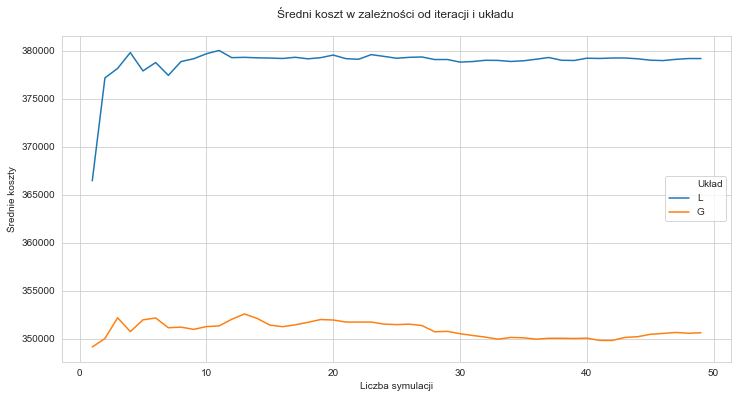

In [91]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Liczba symulacji', y='Średnie koszty', hue='Układ')
plt.title('Średni koszt w zależności od iteracji i układu \n')
plt.show()

Z analizy wynika, ze wraz ze wzrostem liczby symulacji średni koszt całkowity stabilizuje się. W układzie liniowym jest zawsze wyższy niż w układzie gniazdowym.

W dalszym kroku przeprowadzono analizę wartości odchylenia standardowego
całkowitych kosztów w zależności od liczby powtórzeń symulacji. W tym celu dokonano n-krotnej symulacji, gdzie n znajdowało się w przedziale [1, 30]. Przyjęto przy tym stały koszt
jednostkowy przestoju na poziomie 6 jednostek/min, koszt narzędzi kształtujący się na poziomie 5 000
zł oraz stałą różnicę pomiędzy kosztem instalacji układu gniazdowego a liniowego wynoszącą
20 000 jednostek. 

In [65]:
iterations = range(1, 50)
odchylenia = []
for i in iterations:
    odchylenia.append(run_model_3(i, horizon, avg_working_time, avg_repair_time, n, m, 'L', c, cost_inst, m_cost)[2])

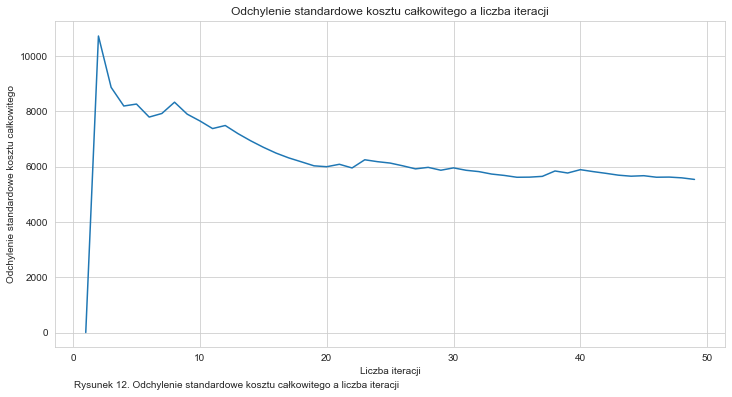

In [75]:
iterations = []
for i in range(1, 50):
    iterations.append(i)

plt.figure(figsize=(12,6))
plt.plot(iterations, odchylenia)
plt.ylabel("Odchylenie standardowe kosztu całkowitego")
plt.xlabel("Liczba iteracji")
plt.title("Odchylenie standardowe kosztu całkowitego a liczba iteracji")
plt.text(0.1, -2000, "Rysunek 12. Odchylenie standardowe kosztu całkowitego a liczba iteracji", ha='left')

plt.show()

Na powyższym wykresie widać, że wraz z wzrostem liczby iteracji odchylenie standardowe kosztu całkowitego się stabilizuje i jest niższe niż przy mniejszej liczbie symulacji.

## 5. Wnioski i zalecenia


Niniejszy raport przedstawia obszerną analizę wpływu kosztów przedsiębiorstwa na optymalne decyzje w prowadzeniu działalności. W głównej mierze opiera się ona na minimalizacji całkowitych kosztów. 

Zgodnie z analizami wynika, że optymalna liczba zestawów narzędzi dla układu liniowego nie zależy w dużym stopniu od poziomu kosztu jednostkowego przestoju. Gdy koszt narzędzi jest między 5 000 PLN a 20 000 PLN, to optymalna liczba narzędzi wynosi 4, natomiast gdy koszt zestawu przekracza 20 000 PLN  to optymalna liczba narzędzie wynosi 3. Dodatkowo widzimy, że dla mniejszych wartości jednostkowego kosztu przestoju, optymalna liczba narzędzi jest niższa. Najcześciej występującym rozwiązaniem optymalnym jest wartość 3. Taka liczba zestawów narzędzi jest rekomendowana dla przedsiębiorstwa, gdy maszyny są ustawione w układzie liniowym.

W układzie gniazdowym mamy do czynienia z podobną sytuacją jak w układzie liniowym. Optymalna liczba urządzeń zmienia się w podobny sposób dla różnych kosztów jednostkowego przestoju. Tutaj również najczęstszą optymalną liczbą narzędzi jest wartość 3. Podobnie często występującym rozwiązaniem optymalnym jest liczba 2. 

W celu wyboru najbardziej optymalnego rozwiązania został stworzony model Drzewa Decyzyjnego, w którym zbiór danych został podzielony w proporcjach 75:25 (trening / test), z maksymalną głebokością równą 4 - aby nie przeuczyć modelu. Model ten jest pomocny dla przedsiębiorstwa w kwestii podjęcia jednogłośnej decyzji nt. liczby narzędzi. Jeżeli koszt zestawu jest z przedziału 11 500 PLN, a 20 500 PLN oraz jednostkowy koszt przestoju jest wiekszy niż 4.5 w układzie liniowym, to przedsiębiorstwo powinno zakupić 4 zestawy narzędzi. 

Dodatkowym wnioskiem z analizy jest fakt, że wraz ze wzrostem kosztu przestoju przewage nad układem liniowym uzyskuje układ gniazdowy. W takim układzie każda maszyna jest zlokalizowana w niedużej odłegłości od siebie tj. czas dostarczania narzędzi do maszyny jest krótszy niż w układzie liniowym. 

Następnym wnioskiem wynikającym z analizy jest stosunek między kosztem instalacji a kosztem przestoju - można zauważyć, że jeśli koszt przestoju spadnie o 1 jednostkę to róznica w koszcie instalacji może spaść maksymalnie o ok. 8 000 PLN, a rozwiązanie optymalne się nie zmieni. 

Dla takich założeń wskazano, że optymalnym rozwiązaniem jest instalacja układu gniazdowego linii produkcyjnej oraz zakup 3 zestawów narzędziowych

Mamy nadzieje, że powyższa analiza symulacyjna i przesdstawione wnioski oraz rekomdancje umożliwią firmie GWINTEX S.A. na podjęcie najbardziej optymalnych decyzji w związku z budową nowej hali produkcyjnej. 


